In [3]:
#Upload das bibliotecas
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn import metrics

In [35]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
#Upload dos dados
df = pd.read_csv('../dags/data/orders.csv', index_col=0)

#Transformando datas em dados datetime
df['modifieddate'] = pd.to_datetime(df['modifieddate'], format='%Y-%m-%d %H:%M:%S')
df['date_month'] = df['modifieddate'].dt.strftime('%Y-%m')

#Selecionando apenas um produto para prever a sua demanda
df = df.groupby(by=['date_month', 'productid']).agg({"orderqty": "sum", "unitprice": "mean"}).reset_index()

#Calculando o total de vendas mensal do produto
df['total_sales'] = df.orderqty*df.unitprice

#Separando a variável 'date_month' em duas variáveis
df[['year', 'month']] = df['date_month'].str.split('-', 1, expand=True)

#Dropando colunas desnecessários para as próximas etapas do projeto
df = df.drop(["orderqty", "unitprice", "date_month"], axis = 1)

<AxesSubplot:>

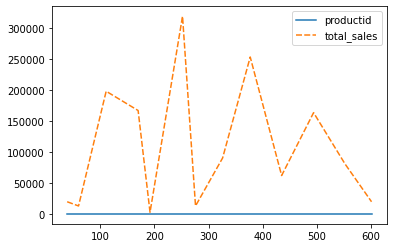

In [8]:
#Vendas totais do produto
sns.lineplot(df[df.productid == 771])

In [5]:
def get_scores(y_true, y_pred):
    """
    - Função: 
        Calcular múltiplas métricas para modelos de regressão
    - Argumentos:
        y_true(pd.Series): target do conjunto de teste
        y_pred(output sklearn model): target inferidas pelo modelo
    """
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    score_dict = {
        'mse': mse,
        'mae': mae,
        'r2': r2
    }
    
    return score_dict

In [ ]:
#Prevendo a demanda do produto 771
df_707 = df[df['productid']==707]

#Separando target
X = df_707.drop(['total_sales'], axis = 1)
y = df_707['total_sales']

#Separando em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para transformação de variáveis numéricas
categorical_features = ['year', 'month']
categorical_transformer = Pipeline(
    steps=[('onehotencoding', OneHotEncoder(handle_unknown = "ignore", sparse=False)), ('scaler', StandardScaler())]
)

# Pipeline de pré-processamento geral das variáveis (numéricas e categóricas)
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough'
)

#Pipeline do pré-procesammento e treinamento do modelo
model_pipeline = Pipeline(
   steps=[('preprocessor', preprocessor), 
          ('regressor', ElasticNet())]
)

#Grade de parâmetros para consulta
params_grid = {
    "regressor__alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    "regressor__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Instanciar grid search e treinar modelo com 10 k-folds
grid_search = GridSearchCV(model_pipeline, param_grid=params_grid, cv=10, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

#Seleção do melhor modelo
model_pipeline = grid_search.best_estimator_

# Calcular métricas para dados de treino e de teste com modelo final
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# Salvar métricas em um dataframe
df_metrics = pd.DataFrame([
    get_scores(y_train, y_pred_train),
    get_scores(y_test, y_pred_test)
], index=['train','test']).rename_axis('input_data')

In [11]:
import os
import joblib

# Criar pasta para salvar as metricas
os.makedirs('metrics', exist_ok=True)

# Salvar métricas em um dataframe
df_metrics = pd.DataFrame([
    get_scores(y_train, y_pred_train),
    get_scores(y_test, y_pred_test)
], index=['train','test']).rename_axis('input_data')
# Criar pasta para salvar as metricas
os.makedirs('metrics', exist_ok=True)
# Log das métricas como csv e html
df_metrics.to_csv('metrics/metrics.csv')
# Log das métricas na sessão de métricas
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_test = metrics.r2_score(y_test, y_pred_test)
metricas = {"MAE_train": mae_train, "MAE_test": mae_test, "r2_train": r2_train, "r2_test": r2_test}
# Criar pasta para salvar os plots
os.makedirs('models', exist_ok=True)
# Serialização do modelo
joblib.dump(model_pipeline, filename = 'models/model_707.pkl')

['models/model_707.pkl']

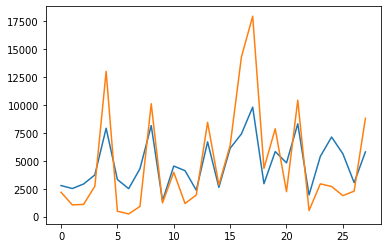

In [123]:
import matplotlib.pyplot as plt

reais = pd.DataFrame(y_train.values)
plt.plot(reais.index, y_pred_train)
plt.plot(reais.index, y_train)

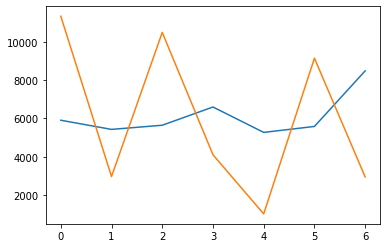

In [124]:
import matplotlib.pyplot as plt

reais = pd.DataFrame(y_test.values)
plt.plot(reais.index, y_pred_test)
plt.plot(reais.index, y_test)

In [7]:
model_pipeline.named_steps['regressor'].get_params()

{'alpha': 10,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [8]:
metrics.mean_absolute_error(y_train, y_pred_train)

2343.0991916816447